# ****Check GPU****

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is being used!")
    except RuntimeError as e:
        print(e)

2025-04-25 06:32:28.437456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745562748.884820      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745562749.014393      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU is being used!


# **Import Dataset**

In [2]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam 
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image

In [3]:
import kagglehub
import os

# Download the dataset from KaggleHub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

# Match GitHub structure by creating a new parent dir name
dataset_directory_location = os.path.join(path)
os.listdir(dataset_directory_location)

# GitHub-style train/test folder names (manually renamed or aliased from 'Training' and 'Testing')
train_dataset_location = os.path.join(dataset_directory_location, 'Training')  # or 'train' if renamed
test_dataset_location = os.path.join(dataset_directory_location, 'Testing')    # or 'test' if renamed

# Check the contents to confirm
if os.path.exists(train_dataset_location) and os.path.exists(test_dataset_location):
    print("✅ Train and Test Paths Exist")
    print("🧠 Train Classes:", os.listdir(train_dataset_location))
    print("🧠 Test Classes:", os.listdir(test_dataset_location))
else:
    raise FileNotFoundError("❌ Error: Train or Test path does not exist.")

✅ Train and Test Paths Exist
🧠 Train Classes: ['pituitary', 'notumor', 'meningioma', 'glioma']
🧠 Test Classes: ['pituitary', 'notumor', 'meningioma', 'glioma']


In [4]:
print("Base path:", path)
print("Contents:", os.listdir(path))

Base path: /kaggle/input/brain-tumor-mri-dataset
Contents: ['Training', 'Testing']


# **Dataset Loading and Preprocessing**

In [5]:
correct_image_shape = (224, 224, 3)

train_image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
).flow_from_directory(
    train_dataset_location,
    target_size=correct_image_shape[:2],
    batch_size=16,
    class_mode='categorical'
)

test_image_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    test_dataset_location,
    target_size=correct_image_shape[:2],
    batch_size=16,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# **Sample Visualisation**

(512, 512, 3)

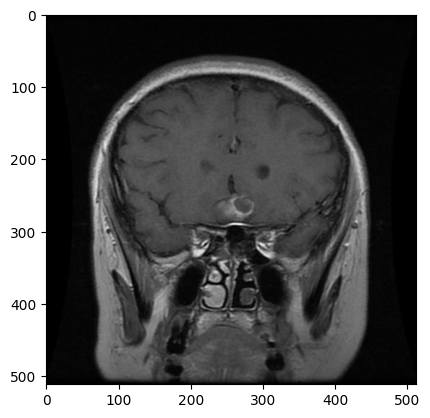

In [20]:
brain_img_glicoma = os.path.join(train_dataset_location, 'pituitary')
os.listdir(brain_img_glicoma)[:1]
brain_img_glicoma_read = imread(os.path.join(brain_img_glicoma, 'Tr-piTr_0009.jpg'))
plt.imshow(brain_img_glicoma_read)
brain_img_glicoma_read.shape 

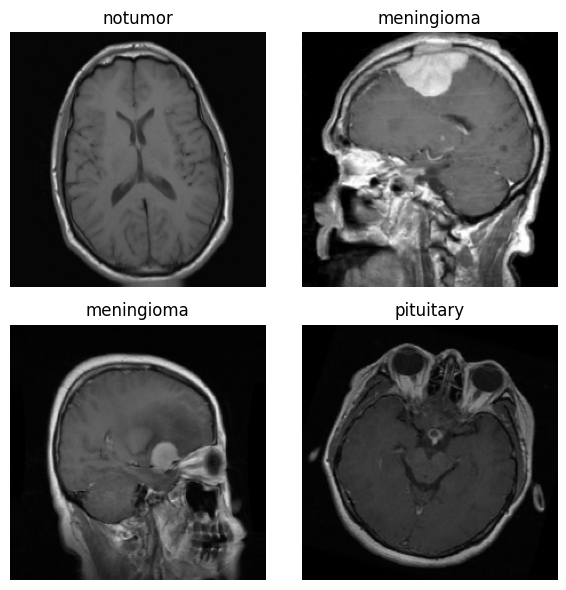

In [21]:
import matplotlib.pyplot as plt

# Helper function to show images from the generator
def show_images(generator, class_names, num_images=4):
    images, labels = next(generator)  # fetch one batch
    plt.figure(figsize=(6, 6))
    for i in range(num_images):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i].argmax()])  # decode one-hot
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Extract class names from the generator itself
class_names = list(train_image_gen.class_indices.keys())

# Call the function with your training generator
show_images(train_image_gen, class_names)

# **Build and Train Model**

In [26]:
from tensorflow.keras.applications import InceptionV3

# Load InceptionV3 base model
inception_model = InceptionV3 (weights='imagenet', include_top=False, input_shape=correct_image_shape) 
inception_model.trainable = False

# Build the model 
model = Sequential() 
model.add(inception_model)

model.add(Flatten())

model.add(BatchNormalization())

model.add(Dense (128, activation = 'relu')) 
model.add(BatchNormalization())

model.add(Dropout (0.3))

model.add(Dense (32, activation = 'relu')) 
model.add(BatchNormalization())

model.add(Dropout (0.3))
model.add(Dense (4, activation = 'softmax')) # 4 classes 
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_201              │ (None, 51200)               │         204,800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_202              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_203              │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,566,212 (108.97 MB)

 Trainable params: 6,660,708 (25.41 MB)

 Non-trainable params: 21,905,504 (83.56 MB)

In [27]:
from IPython.display import FileLink, display
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import json

# Constants for saving
MODEL_PATH = "/kaggle/working/inception_model.keras"
HISTORY_PATH = "/kaggle/working/inception_history.json"

# Early stopping and checkpoint callbacks
early_stop_loss = EarlyStopping(monitor='loss', patience=2, verbose=1)
early_stop_val_loss = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)

checkpoint_cb = ModelCheckpoint(
    MODEL_PATH,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Compile the InceptionV3 model
model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=1e-4),  # Adjust if needed
    metrics=['accuracy']
)

# Train the InceptionV3 model
history = model.fit(
    train_image_gen,
    validation_data=test_image_gen,
    epochs=30,
    callbacks=[early_stop_loss, early_stop_val_loss, checkpoint_cb]
)

# Save training history
with open(HISTORY_PATH, "w") as f:
    json.dump(history.history, f)

# Display download links
print("✅ InceptionV3 model and training history saved!")
display(FileLink(MODEL_PATH, result_html_prefix="📥 Download Inception model: "))
display(FileLink(HISTORY_PATH, result_html_prefix="📊 Download training history: ")) 


Epoch 1/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.6998 - loss: 0.8125
Epoch 1: val_accuracy improved from -inf to 0.86957, saving model to /kaggle/working/inception_model.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 107s 236ms/step - accuracy: 0.7000 - loss: 0.8120 - val_accuracy: 0.8696 - val_loss: 0.3609
Epoch 2/30
356/357 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.8442 - loss: 0.4580
Epoch 2: val_accuracy improved from 0.86957 to 0.89779, saving model to /kaggle/working/inception_model.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 73s 202ms/step - accuracy: 0.8442 - loss: 0.4579 - val_accuracy: 0.8978 - val_loss: 0.2784
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8809 - loss: 0.3577
Epoch 3: val_accuracy improved from 0.89779 to 0.91915, saving model to /kaggle/working/inception_model.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 72s 199ms/step - accuracy: 0.8809 - loss: 0.3576 - val_accuracy: 0.9191 - val_loss: 0.2329
Epoch 4/30
356/357 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms

/kaggle/working/inception_model.keras

/kaggle/working/inception_history.json

# **Graphical Loss vs Accuracy plot**

In [29]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.to_csv("/kaggle/working/training_history.csv", index=False)

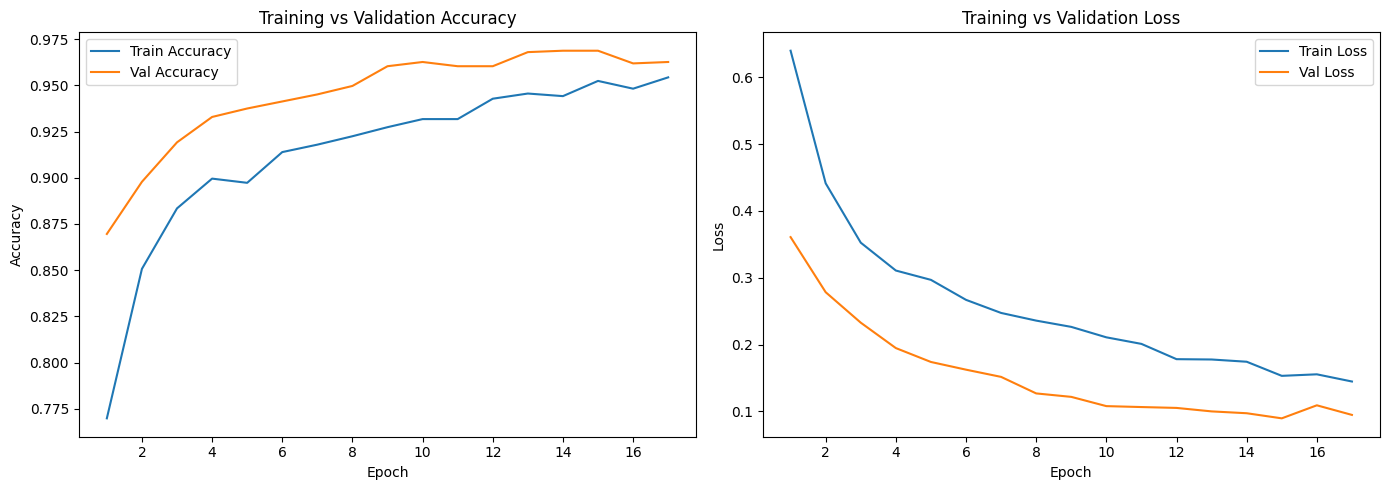

In [30]:
import matplotlib.pyplot as plt

# Load history from the DataFrame (already created)
acc = history_df["accuracy"]
val_acc = history_df["val_accuracy"]
loss = history_df["loss"]
val_loss = history_df["val_loss"]

epochs = range(1, len(acc) + 1)

# Create a figure with two subplots
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Val Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# **Model Evaluation**

In [31]:
# Compile model before evaluation (required for .evaluate and .predict)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Evaluate on training data
train_acc = model.evaluate(train_image_gen, steps=len(train_image_gen))[1]

# Evaluate on test data
test_acc = model.evaluate(test_image_gen, steps=len(test_image_gen))[1]

print(f"✅ Final Train Accuracy: {train_acc:.4f}")
print(f"✅ Final Test Accuracy: {test_acc:.4f}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 76s 184ms/step - accuracy: 0.9844 - loss: 0.0491
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.9642 - loss: 0.0829
✅ Final Train Accuracy: 0.9870
✅ Final Test Accuracy: 0.9687


# **Sample Prediction**

In [32]:
# Choose an image path to test
img_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_0026.jpg"

# Load and preprocess the image
sample_img_load = image.load_img(img_path, target_size=correct_image_shape)
sample_img_to_arr = image.img_to_array(sample_img_load)
sample_img_to_arr = sample_img_to_arr / 255.0  # Normalize
sample_img_to_arr_expand_dim = np.expand_dims(sample_img_to_arr, axis=0)

# Predict
prediction = model.predict(sample_img_to_arr_expand_dim)[0]
pred_result = np.argmax(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


In [33]:
# Define class names in order of training
class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']
pred_final_result = class_names[pred_result]

# Output
print(f"🧠 Predicted Tumor Type: {pred_final_result}")

🧠 Predicted Tumor Type: no tumor
